<a href="https://colab.research.google.com/github/JalalSayed1/AI-Coursework/blob/master/opt_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, we are going to implement see if we can optimally select a subset of training instances for supervised learning.

In [ ]:
pip install -U scikit-learn scipy matplotlib

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-11-10 22:00:01.702811: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 22:00:01.704728: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-10 22:00:01.740892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 22:00:01.740923: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 22:00:01.740944: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

We are going to work with the MNIST dataset, a popular dataset for hand-written digit recognition. Here we load the datatset.

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1) # 28x28 pixel images with 1 colour channel (grayscale)

# Load the data and split it between train and test sets
# x = images, y = labels
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 # 0-255 to 0-1
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # -1 means last dimension
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("Loaded {} train samples".format(x_train.shape[0]))
print("Loaded {} test samples".format(x_test.shape[0]))

x_train shape: (60000, 28, 28, 1)
Loaded 60000 train samples
Loaded 10000 test samples


Now corrupt the labels with common types of mistakes. The variable 'noise_probability' controls the amount of errors introduced.

In [3]:
import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0:
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        # generate a random number between 0 and 1:
        p = random.random()

        #! if p > noise_probability, then we do not corrupt the label?
        if p < noise_probability:
            y = y_train[i]
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))


Corruptions: {'0->3': 665, '1->5': 698, '9->8': 723, '1->2': 664, '3->0': 690, '4->3': 619, '3->8': 716, '5->3': 639, '3->6': 730, '6->3': 675, '1->6': 662, '7->6': 610, '2->3': 703, '8->5': 684, '4->8': 602, '0->9': 704, '9->0': 675, '1->3': 630, '2->5': 677, '2->0': 689, '7->3': 587, '8->2': 683, '9->2': 695, '5->2': 638, '6->2': 718, '6->8': 664, '7->5': 684, '5->8': 657, '3->9': 738, '0->5': 703, '7->8': 631, '4->9': 562, '0->6': 683, '4->2': 541, '4->6': 615, '6->0': 668, '0->2': 661, '5->0': 618, '0->8': 725, '2->9': 690, '9->5': 653, '8->6': 697, '6->5': 687, '7->2': 622, '8->9': 705, '1->0': 679, '1->9': 695, '2->8': 674, '3->5': 739, '2->6': 681, '6->9': 726, '1->8': 716, '7->9': 593, '4->5': 580, '5->9': 592, '9->6': 660, '9->3': 720, '8->0': 645, '3->2': 732, '7->0': 609, '5->6': 646, '4->0': 567, '8->3': 711}
Corrupted indexes: [1, 3, 4, 6, 7, 8, 9, 10, 11, 12]


In [4]:
# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

Supervised (parametric) training with the (noisy) labeled examples. Note that this model is trained on the entire dataset (the value of the parameter pruned_indexes is null here, which means that we leave out no points), which is noisy (20% of the labels are corrupted). Now the question is: is this the best model that we can train or can we do better?

In [5]:
batch_size = 128
epochs = 3 # very high epochs might overfit the model.
validation_split=0.1


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

def prune_points(x_train, y_train, pruned_indexes):
    num_samples = x_train.shape[0] # = 60000
    x_train_pruned = []
    y_train_pruned = []
    for i in range(num_samples):
        if not i in pruned_indexes:
            x_train_pruned.append(x_train[i])
            y_train_pruned.append(y_train[i])

    return np.array(x_train_pruned), np.array(y_train_pruned)

def trainAndEvaluateModel(x_train, y_train, x_test, y_test, model, pruned_indexes):

    if not pruned_indexes == None:
        x_train_pruned, y_train_pruned = prune_points(x_train, y_train, pruned_indexes)
    else:
        x_train_pruned = x_train
        y_train_pruned = y_train

    # start training the model:
    model.fit(x_train_pruned, y_train_pruned, batch_size=batch_size, epochs=epochs)
    model.evaluate(x_test, y_test)
    keras.backend.clear_session() # remove previous training weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dropout (Dropout)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

And we call the following function to train a model on the entire dataset and evaluate it on the test set. The accuracy on the test set is quite good, but can we do better?

In [6]:
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, None)

Epoch 1/3
469/469 [==============================] - 7s 14ms/step - loss: 1.9965 - accuracy: 0.2444
Epoch 2/3
469/469 [==============================] - 7s 14ms/step - loss: 1.9531 - accuracy: 0.2711
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 1.4050 - accuracy: 0.8699


You need to implement a subset selection function that when called will return a subset of instances which will be used to train the model. This setup ensures that you also pass in another dictionary which contains the indexes of the instances that you would not want to use while training the model, i.e., it should contain a list of indexes that you would decide to **leave out** for training.

Here's the code and a sample implementation that returns a randomly chosen set of instances that you are to be left out. Since we chose 70% probability of label corruption (check the **noise_probability** parameter), we also select a subset where we leave out the same proportion of points. This is a baseline implementation and obviously you should aim to achieve better results than this.

In [9]:
# Here 'x_train', 'y_train' and model' are an unused parameters. But you may get better results by leveraging these.
def baseLinePrunedSubsetMethod(x_train, y_train, model):
    pruned_indexes = {}
    num_samples = x_train.shape[0]
    for i in range(num_samples):
        p = random.random()

        if p < noise_probability: # this is the global variable (only useful for this naive approach)
            pruned_indexes[i] = i
    return pruned_indexes

Let's see how this naive baseline works.

In [12]:
pruned_indexes = baseLinePrunedSubsetMethod(x_train, y_train, model)
# print (f"pruned_indexes: {pruned_indexes}")
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)

pruned_indexes: {0: 0, 1: 1, 2: 2, 3: 3, 5: 5, 7: 7, 8: 8, 11: 11, 12: 12, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 25: 25, 26: 26, 27: 27, 28: 28, 30: 30, 31: 31, 32: 32, 35: 35, 36: 36, 38: 38, 40: 40, 41: 41, 42: 42, 43: 43, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 61: 61, 62: 62, 63: 63, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 93: 93, 94: 94, 95: 95, 96: 96, 98: 98, 99: 99, 100: 100, 101: 101, 103: 103, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 123: 123, 125: 125, 126: 126, 127: 127, 128: 128, 129: 129, 130: 130, 131: 131, 132: 132, 133: 133, 134: 134, 137: 137, 138: 138, 139: 139, 142: 142, 143: 143, 144: 144, 145: 145, 146: 146, 1

Let's now see if we had known what points were actually corrupted (more of a hypothetical unrealistic situation), does leaving out those points actually improve the model's effectiveness. It turns out that it does!

In [9]:
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, corrupted_indexes)

Epoch 1/3
141/141 [==============================] - 2s 14ms/step - loss: 0.3781 - accuracy: 0.9125
Epoch 2/3
141/141 [==============================] - 2s 15ms/step - loss: 0.1976 - accuracy: 0.9445
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1307 - accuracy: 0.9612


Your task is to implement your own version of (say of name **myPrunedSubsetMethod** (which should take as arguments x_train, y_train, and the model). The function should return a dictionary of indexes that are to be left out. Plug your function in and evaluate the results. Write a thorough report on the methodology and analyse the results.

Some hints:
You can approach this as a discrete state space optimisation problem, where firstly you can define a "selection batch size" (this is not the same as training batch size), which decides which batch of instances you're going to leave out. For instance, if you are in a state where the training set is $X$, you may select (by some heuristics) which points you're gonna leave out (let that set be $\delta \subset X$) so that a child state becomes $X' = X - \delta$. Similarly, if you choose a different $\delta$ you get a different child state. You then need to train and evaluate (call the function *trainAndEvaluateModel*) to see if that child state led to an improvement or not.

You are free to use any algorithm, e.g., simulated annealing, A* search, genetic algorithm etc. to implement this discrete state space optimisation.

In [2]:

#! remove this:

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1) # 28x28 pixel images with 1 colour channel (grayscale)

# Load the data and split it between train and test sets
# x = images, y = labels
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 # 0-255 to 0-1
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # -1 means last dimension
x_test = np.expand_dims(x_test, -1)

import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0:
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        # generate a random number between 0 and 1:
        p = random.random()

        #! if p > noise_probability, then we do not corrupt the label?
        if p < noise_probability:
            y = y_train[i]
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))

# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

loss_list = []
acc_list = []

batch_size = 128
epochs = 3 # very high epochs might overfit the model.
validation_split=0.1


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

def prune_points(x_train, y_train, pruned_indexes):
    num_samples = x_train.shape[0] # = 60000
    x_train_pruned = []
    y_train_pruned = []
    for i in range(num_samples):
        if not i in pruned_indexes:
            x_train_pruned.append(x_train[i])
            y_train_pruned.append(y_train[i])

    return np.array(x_train_pruned), np.array(y_train_pruned)

def trainAndEvaluateModel(x_train, y_train, x_test, y_test, model, pruned_indexes):

    if not pruned_indexes == None:
        x_train_pruned, y_train_pruned = prune_points(x_train, y_train, pruned_indexes)
    else:
        x_train_pruned = x_train
        y_train_pruned = y_train

    # start training the model:
    model.fit(x_train_pruned, y_train_pruned, batch_size=batch_size, epochs=epochs)
    
    #! remove this:
    loss, accuracy = model.evaluate(x_test, y_test)
    loss_list.append(loss) #! remove this
    acc_list.append(accuracy) #! remove this

    keras.backend.clear_session() # remove previous training weights


2023-11-11 21:16:28.867319: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-11 21:16:28.890756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 21:16:29.006086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 21:16:29.006120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 21:16:29.006772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Corruptions: {'5->3': 633, '1->8': 677, '9->0': 674, '2->5': 685, '1->6': 623, '3->0': 752, '3->2': 717, '6->2': 660, '7->0': 678, '2->6': 697, '6->9': 689, '9->8': 706, '4->9': 549, '0->8': 669, '1->0': 694, '2->0': 674, '7->2': 622, '8->2': 693, '6->8': 725, '9->5': 689, '6->3': 648, '6->5': 722, '1->2': 651, '8->5': 699, '7->5': 629, '3->6': 699, '8->0': 664, '5->2': 692, '3->8': 729, '7->9': 642, '9->6': 714, '0->6': 713, '4->0': 625, '0->2': 680, '5->0': 633, '0->3': 657, '1->5': 662, '7->3': 584, '0->5': 703, '1->3': 695, '9->3': 670, '0->9': 676, '8->6': 641, '8->3': 713, '7->8': 638, '1->9': 655, '5->9': 624, '4->5': 564, '2->3': 721, '4->6': 604, '3->5': 707, '5->8': 674, '4->2': 599, '2->8': 751, '5->6': 596, '2->9': 670, '6->0': 683, '8->9': 667, '9->2': 646, '4->8': 585, '4->3': 587, '3->9': 693, '7->6': 625}
Corrupted indexes: [0, 3, 4, 5, 6, 7, 8, 10, 11, 12]
Model: "sequential"
_________________________________________________________________
 Layer (type)               


Running iteration 0
Epoch 1/3
469/469 [==============================] - 7s 15ms/step - loss: 1.9229 - accuracy: 0.2832
Epoch 2/3
469/469 [==============================] - 7s 14ms/step - loss: 1.9200 - accuracy: 0.2819
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 1.3421 - accuracy: 0.9105

Running iteration 1
Epoch 1/3
469/469 [==============================] - 6s 13ms/step - loss: 1.9146 - accuracy: 0.2850
Epoch 2/3
469/469 [==============================] - 6s 13ms/step - loss: 1.9122 - accuracy: 0.2858
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 1.3669 - accuracy: 0.9106

Running iteration 2
Epoch 1/3
469/469 [==============================] - 6s 13ms/step - loss: 1.9063 - accuracy: 0.2871
Epoch 2/3
469/469 [==============================] - 6s 13ms/step - loss: 1.9058 - accuracy: 0.2875
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 1.3911 - accuracy: 0.9012

Running iteration 3
Epoch 1/3
469/469 [

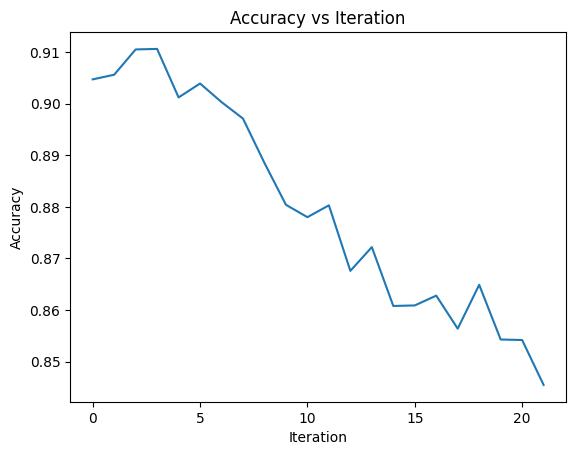

In [4]:
def myPrunedSubsetMethod(x_train, y_train, model):
    pruned_indexes = {}

    # TODO: implement algorithm here


    pruned_indexes[0] = 0 # update dict
    
    return pruned_indexes

# print(f"pruned_indexes: {pruned_indexes}")
for i in range(20):
    print(f"\nRunning iteration {i}")
    pruned_indexes = myPrunedSubsetMethod(x_train, y_train, model)
    # print(f"Pruned indexes: {pruned_indexes}\n")
    trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)

print (f"Loss: {loss_list}")
print (f"Accuracy: {acc_list}")

import matplotlib.pyplot as plt
plt.plot(acc_list)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.title('Accuracy vs Iteration')
plt.show()
